# VISHNU

This notebook will detail the process of sorting between accreted Milky Way Globular Clusters and in-situ globular clusters using solely dynamical information. The obtained accretion candidates list is to be used in further age-metallicity comparisons to examine the physical differences between these two groups of GC's. 

The general approach to identify accretion candidates from dynamical information will be as follows:

1. Begin from the E-Lz plot and flag clusters with high energy (bigger E means the cluster is likely less bound, 
hence more likely to be accreted) OR clusters with retrograde orbits (Lz < 0), which is another clear sign of accretion

2. Make a dynamical cut in the negative Lz, high energy region of the plot. Ensure that the cut is broad, so that candidates which don't fit the trend spatially can be removed later. Expect approximately 30-45 GC's within the cut before trimming. 

3. Next, plot candidates against the remaining population spatially (R vs |z|), in terms of eccentricity (eccentricity vs E) and in terms of their apocentric distances. Determine if these candidates are outliers in these plots as well. If they are, then this is a further sign of accretion. If they are not, and don't fit the trend spatially, then remove them from the accretion candidates list. 

4. Compare with the age-metallicity plots from Sav. Cross check that the candidates are generally younger and more metal-poor than the 
in-situ population. Cross any off the list that are not. We will end up then with a final list of accretion candidates.



## Data preparation

In [2]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import astropy as ap
from astropy import units as u
import pandas as pd
import astroquery as aq
from astropy.coordinates import SkyCoord, ICRS, Galactic, Galactocentric
from galpy.potential import MWPotential2014
from galpy.orbit import Orbit

In [3]:
# Read in the data

positions_df = pd.read_csv(r"C:\Users\vishn\Desktop\University(work)\PHYS3116 (Galaxies + Cosmology)\Computational Assignment\Data\HarrisPartI.csv")
velocities_df = pd.read_csv(r"C:\Users\vishn\Desktop\University(work)\PHYS3116 (Galaxies + Cosmology)\Computational Assignment\Data\HarrisPartIII.csv")
data_df = pd.merge(positions_df, velocities_df, on="ID")

print(data_df.keys())

# Extract relevant columns
R_GC = data_df["R_gc"].values * u.kpc  # Galactocentric distance
v_LSR = data_df["v_LSR"].values * u.km / u.s  # Radial velocity
z = data_df["Z"].values * u.kpc  # Height above/below Galactic plane
l = data_df["L"].values * u.deg  # Galactic longitude
b = data_df["B"].values * u.deg  # Galactic latitude
R_sun = data_df["R_Sun"].values * u.kpc  # Distance from Sun

Index(['ID', 'Name', 'RA', 'DEC', 'L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z',
       'v_r', 'v_r_e', 'v_LSR', 'sig_v', 'sig_v_e', 'c', 'r_c', 'r_h', 'mu_V',
       'rho_0', 'lg_tc', 'lg_th'],
      dtype='object')


## E-Lz plotting and analysis

Accretion candidates based on E-Lz criteria:
['Arp2' 'NGC5024' 'Crater' 'IC4499' 'Pal4' 'NGC5694' 'NGC2298' 'NGC4147'
 'Pal14' 'NGC7089' 'NGC5272' 'NGC6934' 'NGC6101' 'NGC5466' 'Pal5' 'Pal15'
 'Pal13' 'NGC5053' 'NGC6715' 'Pal2' 'NGC1261' 'Whiting1' 'NGC5634'
 'NGC7492' 'Terzan7' 'NGC5904' 'IC1257' 'NGC2419' 'NGC7006' 'NGC6584'
 'NGC3201' 'NGC6229' 'Pyxis' 'NGC1904' 'NGC1851' 'Terzan8' 'NGC6981' 'E1'
 'NGC6864' 'Eridanus' 'AM4' 'FSR1758']
Number of accretion candidates: 42


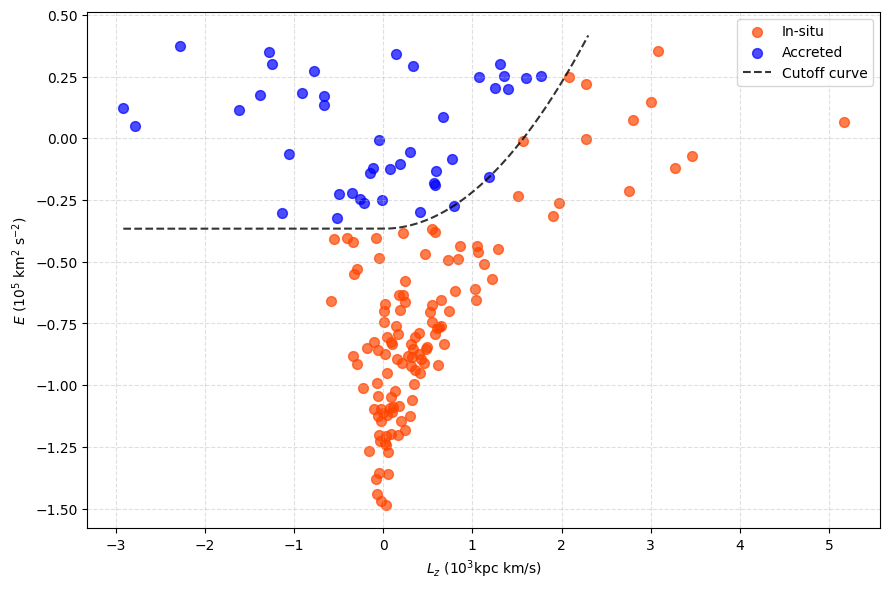

'\n# Normalize Harris catalogue IDs: remove spaces, uppercase\nharris_ids_norm = set(data_df[\'ID\'].str.replace(" ", "", regex=False).str.upper())\n\n# Normalize accretion candidate names the same way\ncandidates_norm = [gc.replace(" ", "").upper() for gc in accretion_candidates]\n\n# Check membership\nmatches = [gc for gc in candidates_norm if gc in harris_ids_norm]\nmissing = [gc for gc in candidates_norm if gc not in harris_ids_norm]\n\n# Print results\nprint(f"Total accretion candidates: {len(accretion_candidates)}")\nprint(f"Found in Harris catalogue: {len(matches)}")\nprint(f"Missing from Harris catalogue: {len(missing)}\n")\n\nif matches:\n    print("✅ Matches:")\n    for m in matches:\n        print("  ", m)\n\nif missing:\n    print("\n❌ Missing:")\n    for m in missing:\n        print("  ", m)\n'

In [ ]:
# Harris ID's don't match the naming convention of SIMBAD, so instead I'll be using the Galpy inbuilt globular cluster list
# Galpy globular clusters list. This is fine because SIMBAD pulls from Gaia EDR3 which only has 4 more GC's than Harris. 

# Pulling the inbuilt globular cluster data from galpy
orbits_galpy = Orbit.from_name('MW Globular Clusters')
Lz = []
E = []
names = []
for orb in orbits_galpy:
    names.append(orb.name)
    Lz.append(orb.Lz(pot=MWPotential2014))
    E.append(orb.E(pot=MWPotential2014))

# Extract Lz and E values and convert to numpy arrays
Lz = np.array(Lz, dtype=float)
E = np.array(E, dtype=float)
names = np.array(names)



# Creating a dynamical classification. Soft initial cut. 
L0 = 500
E_cutoff = np.percentile(E, 65)
alpha = alpha = 0.05 * (np.max(E) - E_cutoff) 

def E_boundary(lz):
    return np.where(lz < 0, E_cutoff, E_cutoff + alpha * (lz/L0)**2) # if Lz < 0, straight line, if Lz > 0, parabola
    
mask_accreted = E > E_boundary(Lz)
mask_insitu = np.logical_not(mask_accreted)  # Inverse of accreted mask

# Print the names of the accretion candidate clusters

print("Accretion candidates based on E-Lz criteria:")
accretion_candidates = np.array(names[mask_accreted])
print(accretion_candidates)
print(f"Number of accretion candidates: {len(accretion_candidates)}")

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(Lz[mask_insitu]/1e3,   E[mask_insitu]/1e5,   color='orangered', s=50, alpha=0.7, label='In-situ')
ax.scatter(Lz[mask_accreted]/1e3, E[mask_accreted]/1e5, color='blue',s=50, alpha=0.7, label='Accreted')
lz_grid = np.linspace(Lz.min(), 2300, 400)
ax.plot(lz_grid/1e3, E_boundary(lz_grid)/1e5,c = 'black', ls = '--',alpha = 0.8, label = 'Cutoff curve')
ax.set_xlabel(r'$L_z$ ($10^3$kpc km/s)')
ax.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)')
ax.grid(True, ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()



## Spatial verification

In [ ]:
# Now, fixing up the naming mismatches and spelling mismatches between the Harris catalogue and the Galpy inbuilt catalogue
# Making everything capital letters and remove spaces in Harris dataframe
data_df['ID'] = data_df['ID'].str.replace(" ", "", regex=False).str.upper()
accretion_candidates = np.char.upper(accretion_candidates)         # Making everything capital letters (there's already no spaces)

# The first two are not in the Harris catalogue and were discovered recently, so I will remove them
# The third GC has an orbital radius well within the bulge (~2) and is unlikely to be an accretion candidate
accretion_candidates = accretion_candidates[(accretion_candidates != 'CRATER') & (accretion_candidates != 'FSR1758') 
                                            & (accretion_candidates != 'NGC5904')] 

 # This one is in Harris, but named differently
accretion_candidates = np.where(accretion_candidates == 'E1', 'AM1', accretion_candidates)  

print(accretion_candidates)

# Plotting the spatial distribution again, but this time highlighting the accretion candidates

ap.coordinates.galactocentric_frame_defaults.set('v4.0')
gal_coords = SkyCoord(l=l, b=b, distance=R_sun, frame='galactic')
galcen = gal_coords.transform_to(Galactocentric(galcen_distance=8.0*u.kpc, z_sun=0*u.pc))  # in line with harris catalogue

# store galactocentric coordinates in the data frame
data_df['x_gc'] = galcen.x.to(u.kpc).value
data_df['y_gc'] = galcen.y.to(u.kpc).value
data_df['z_gc'] = galcen.z.to(u.kpc).value

x_gc = data_df['x_gc'].values * u.kpc
y_gc = data_df['y_gc'].values * u.kpc
z_gc = data_df['z_gc'].values * u.kpc  # this is redundant, just keeping it here for the sake of consistency


accretion_mask = data_df['ID'].isin(accretion_candidates)

# Plotting the spatial distributions of GC's 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: x vs z
# Plot the in situ clusters
ax[0].scatter(x_gc[accretion_mask == False], z_gc[accretion_mask == False], s=50, color='orangered', alpha=0.7, label='In Situ')

# Plot the accreted candidates
ax[0].scatter(x_gc[accretion_mask], z_gc[accretion_mask], s=50, color='blue', alpha=0.7, label='Accreted Candidates')
ax[0].set_xlabel(r"x (kpc)", fontsize=14)
ax[0].set_ylabel(r"z (kpc)", fontsize=14)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend()
# Plotting R_xy vs |z|
R_xy = np.sqrt(x_gc**2 + y_gc**2)
z_abs = np.abs(z_gc)

ax[1].scatter(R_xy[accretion_mask == False], z_abs[accretion_mask == False], s=50, color='orangered', alpha=0.7, label='In Situ')
ax[1].scatter(R_xy[accretion_mask], z_abs[accretion_mask], s=50, color='blue', alpha=0.7, label='Accreted Candidates')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r"R = $(x^2 + y^2)^{1/2}$ (kpc)", fontsize=14)
ax[1].set_ylabel(r"|z| (kpc)", fontsize=14)
ax[1].grid(True, which="both", ls="--", alpha=0.6)
ax[1].legend()

plt.tight_layout()
plt.show()
# This was done to add 3 GC's which have spatial distributions characteristic of accretion candidates, even though they didn't make the cut in E-Lz space
# accretion_candidates = np.append(data_df[accretion_mask == False & (np.sqrt(data_df['x_gc']**2 + data_df['y_gc']**2) > 20 * u.kpc)]['ID'].values, accretion_candidates)

45


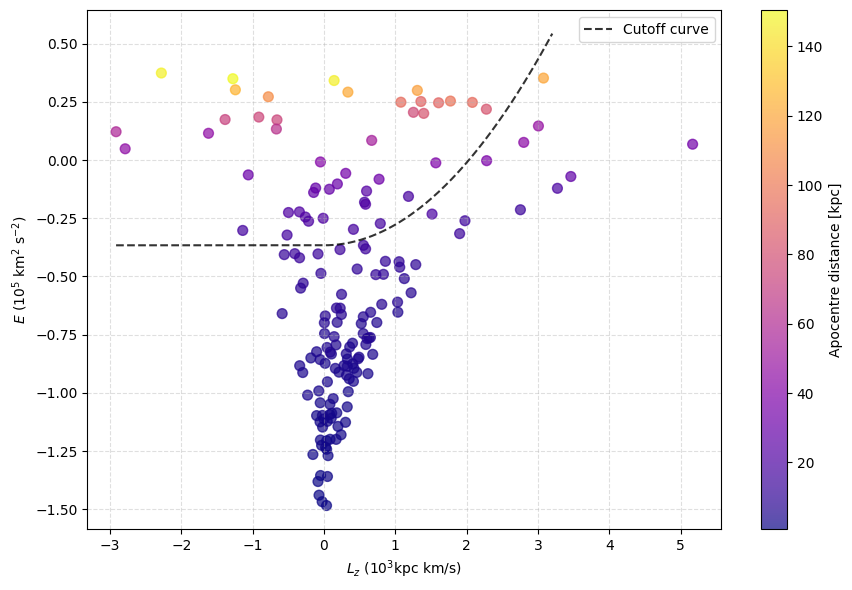

Accretion candidates based on E-Lz criteria:
['Arp2' 'NGC5024' 'Crater' 'IC4499' 'Pal4' 'NGC5694' 'NGC2298' 'NGC4147'
 'Pal14' 'NGC7089' 'NGC5272' 'NGC6934' 'NGC6101' 'NGC5466' 'Pal5' 'Pal15'
 'Pal13' 'NGC5053' 'NGC6715' 'Pal2' 'NGC1261' 'Whiting1' 'NGC5634'
 'NGC7492' 'Terzan7' 'NGC5904' 'IC1257' 'NGC2419' 'Pal12' 'NGC7006'
 'NGC6584' 'NGC3201' 'Rup106' 'NGC6229' 'Pyxis' 'NGC1904' 'NGC1851'
 'Terzan8' 'NGC6981' 'E1' 'NGC6864' 'Eridanus' 'AM4' 'FSR1758' 'Laevens3']
Number of accretion candidates: 45
Total accretion candidates: 42
Found in Harris catalogue: 39
Missing from Harris catalogue: 3

Matches:
   ARP2
   NGC5024
   IC4499
   PAL4
   NGC5694
   NGC2298
   NGC4147
   PAL14
   NGC7089
   NGC5272
   NGC6934
   NGC6101
   NGC5466
   PAL5
   PAL15
   PAL13
   NGC5053
   NGC6715
   PAL2
   NGC1261
   WHITING1
   NGC5634
   NGC7492
   TERZAN7
   NGC5904
   IC1257
   NGC2419
   NGC7006
   NGC6584
   NGC3201
   NGC6229
   PYXIS
   NGC1904
   NGC1851
   TERZAN8
   NGC6981
   NGC6864
   ER

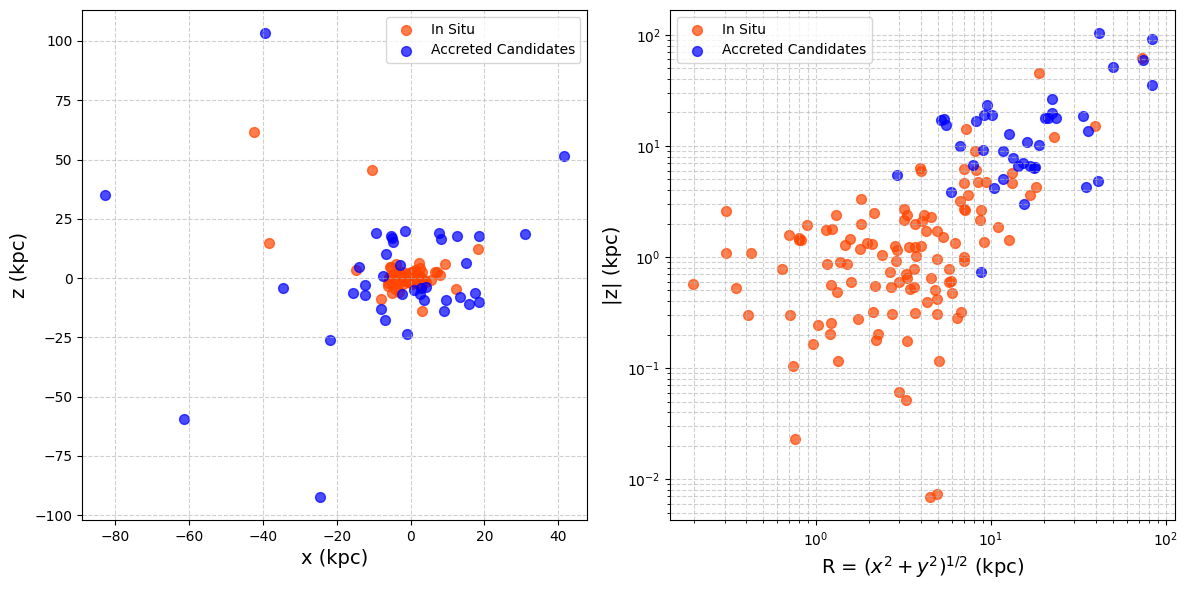

In [ ]:
# Interesting side job - I'll verify the accretion candidates further by looking at their apocentric distances. 

orbits_galpy = Orbit.from_name('MW Globular Clusters')
Lz = []
E = []
apo = []
names = []
for orb in orbits_galpy:
    names.append(orb.name)
    Lz.append(orb.Lz(pot=MWPotential2014))
    E.append(orb.E(pot=MWPotential2014))
    apo.append(orb.rap(pot=MWPotential2014, analytic=True))

Lz = np.array(Lz, dtype=float)
E = np.array(E, dtype=float)
apo = np.array(apo, dtype=float)
names = np.array(names)


# Soft cutoff, softer criteria and narrow down later
L0 = 500
E_cutoff = np.percentile(E, 65)
alpha = alpha = 0.03 * (np.max(E) - E_cutoff) 

def E_boundary(lz):
    return np.where(lz < 0, E_cutoff, E_cutoff + alpha * (lz/L0)**2) # if Lz < 0, straight line, if Lz > 0, parabola

mask_accreted = E > E_boundary(Lz)
print(sum(E > E_boundary(Lz)))
fig, ax = plt.subplots(figsize=(9,6))
sc = ax.scatter(Lz/1e3,   E/1e5, c = apo, cmap = 'plasma', s=50, alpha=0.7)
lz_grid = np.linspace(Lz.min(), 3200, 400)
ax.plot(lz_grid/1e3, E_boundary(lz_grid)/1e5,c = 'black', ls = '--',alpha = 0.8, label = 'Cutoff curve')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Apocentre distance [kpc]')
ax.set_xlabel(r'$L_z$ ($10^3$kpc km/s)')
ax.set_ylabel(r'$E$ ($10^5$ km$^2$ s$^{-2}$)')
ax.grid(True, ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

# Print the names of the accretion candidate clusters
print("Accretion candidates based on E-Lz criteria:")
accretion_candidates1 = np.array(names[mask_accreted])
print(accretion_candidates1)
print(f"Number of accretion candidates: {len(accretion_candidates1)}")


# Normalize Harris catalogue IDs: remove spaces, uppercase
harris_ids_norm = set(data_df['ID'].str.replace(" ", "", regex=False).str.upper())

# Normalize accretion candidate names the same way
candidates_norm = [gc.replace(" ", "").upper() for gc in accretion_candidates]

# Check membership
matches = [gc for gc in candidates_norm if gc in harris_ids_norm]
missing = [gc for gc in candidates_norm if gc not in harris_ids_norm]

# Print results
print(f"Total accretion candidates: {len(accretion_candidates)}")
print(f"Found in Harris catalogue: {len(matches)}")
print(f"Missing from Harris catalogue: {len(missing)}\n")

if matches:
    print("Matches:")
    for m in matches:
        print("  ", m)

if missing:
    print("Missing:")
    for m in missing:
        print("  ", m)
